### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from keras.utils import plot_model


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
!pip install git+https://github.com/jfilter/split-folders.git


  Cloning https://github.com/jfilter/split-folders.git to /tmp/pip-req-build-7oz2_c3u
  Running command git clone --filter=blob:none --quiet https://github.com/jfilter/split-folders.git /tmp/pip-req-build-7oz2_c3u
  Resolved https://github.com/jfilter/split-folders.git to commit c566dbd56a1097e1ddba2de5dfb93bd67eade54f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for split-folders: filename=split_folders-0.5.1-py3-none-any.whl size=8394 sha256=c446c34418b9a2f848aec039aa6df18c12274b0c3582f3996c6f5321d20d8df0
  Stored in directory: /tmp/pip-ephem-wheel-cache-vavsrwiw/wheels/0c/da/06/fcebe493adfe604ee9a1d4511e3932a6e63a044edb7a10dec8
Successfully built split-folders


# **Data Preprocessing**

In [3]:
import splitfolders

# Set the path of the directory containing the original images
input_folder = '/kaggle/input/alzheimer-mri-dataset/Dataset'

# Set the base directory for the split images
output_folder = '/kaggle/working/Splitted'

# Set the ratio of images for each split
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Use the splitfolders library to split the images into train-validation-test sets
splitfolders.ratio(input_folder, output_folder, seed=42,
                   ratio=(train_ratio,
                          validation_ratio,
                          test_ratio))


Copying files: 6400 files [00:37, 171.32 files/s]


In [4]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
IMG_SIZE = (128, 128)
SEED = 1345

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        )
       
validation_datagen = ImageDataGenerator(rescale=1./255)


test_datagen = ImageDataGenerator(rescale=1./255)

# Define directories for train, validation, and test sets
train_dir = '/kaggle/working/Splitted/train'
validation_dir = '/kaggle/working/Splitted/val'
test_dir = '/kaggle/working/Splitted/test'

# Define generators for train and validation sets using flow_from_directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')

# Define generator for test set using flow_from_directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size =64,
        class_mode ='categorical')

epochs = 50

Found 5119 images belonging to 4 classes.
Found 639 images belonging to 4 classes.
Found 642 images belonging to 4 classes.


In [5]:
# class_names = train_generator.class_names
# class_names

class_names = list(train_generator.class_indices.keys())
class_names



['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

# **Data Visualization**

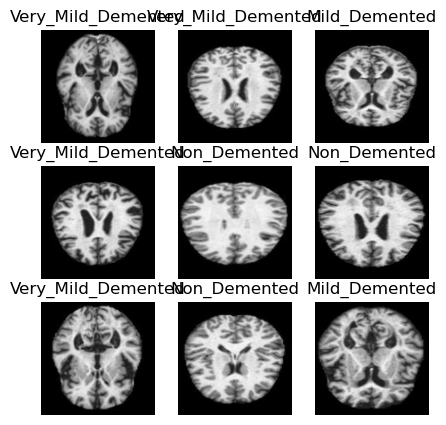

In [6]:
plt.figure(figsize=(5, 5))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break


## Data Augmentation

In [7]:
#preprocessing for rotation and zoom
def data_augmentar():
   
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    
    return data_augmentation

In [8]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

## Solving Imbalanced Data Problem

In [9]:
## Calculate number of samples in each class.
input_folder = '/kaggle/input/alzheimer-mri-dataset/Dataset'
class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

class_counts

{'Mild_Demented': 896,
 'Moderate_Demented': 64,
 'Non_Demented': 3200,
 'Very_Mild_Demented': 2240}

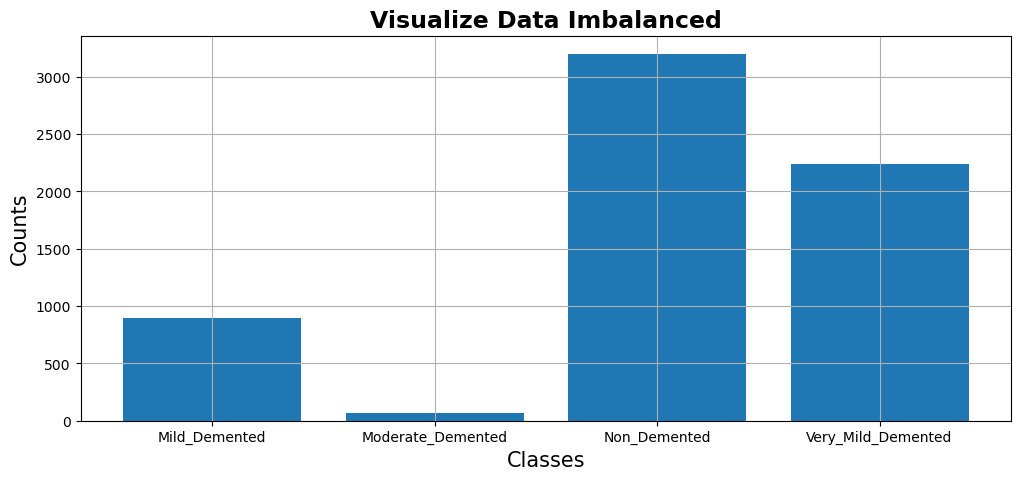

In [10]:
plt.figure(figsize=(12,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes', fontdict={'fontsize':15})
plt.ylabel('Counts', fontdict={'fontsize':15})
plt.title('Visualize Data Imbalanced', fontdict={'fontsize':17,
                                                 'fontweight':'bold'})
plt.grid(True)
plt.show()

In [11]:
# Class_weight = (Total Number of images/Number of class x Images per class )

total = sum(class_counts.values())
number_of_classes = len([ 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented'])

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "Mild_Demented" : 1.79
Weight for class "Moderate_Demented" : 25.0
Weight for class "Non_Demented" : 0.5
Weight for class "Very_Mild_Demented" : 0.71


## **INCEPTION V3**

In [12]:
from tensorflow.keras.applications import InceptionV3
base_model_6 = tf.keras.applications.InceptionV3(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')


87910968/87910968 [==============================] - 0s 0us/step


In [13]:
for layer in base_model_6.layers:
  layer.trainable=False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = keras.layers.Dense(4,activation='softmax')

model4 = tf.keras.Sequential([base_model_6, global_average_layer,
  keras.layers.BatchNormalization(),  
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])



In [15]:
model4.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Train your model with mixed precision
history = model4.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs =50,
                    verbose=1)


Epoch 1/50
80/80 [==============================] - 36s 285ms/step - loss: 1.0034 - accuracy: 0.5319 - auc: 0.8156 - precision: 0.5885 - recall: 0.4093 - val_loss: 0.8945 - val_accuracy: 0.5822 - val_auc: 0.8471 - val_precision: 0.7143 - val_recall: 0.3521
Epoch 2/50
80/80 [==============================] - 20s 253ms/step - loss: 0.8749 - accuracy: 0.5939 - auc: 0.8563 - precision: 0.6547 - recall: 0.4559 - val_loss: 0.8777 - val_accuracy: 0.6088 - val_auc: 0.8589 - val_precision: 0.6770 - val_recall: 0.5117
Epoch 3/50
80/80 [==============================] - 20s 248ms/step - loss: 0.8239 - accuracy: 0.6189 - auc: 0.8728 - precision: 0.6844 - recall: 0.5163 - val_loss: 0.7968 - val_accuracy: 0.6213 - val_auc: 0.8783 - val_precision: 0.6786 - val_recall: 0.5352
Epoch 4/50
80/80 [==============================] - 22s 277ms/step - loss: 0.7933 - accuracy: 0.6232 - auc: 0.8813 - precision: 0.6861 - recall: 0.5304 - val_loss: 0.7928 - val_accuracy: 0.6166 - val_auc: 0.8808 - val_precision: 

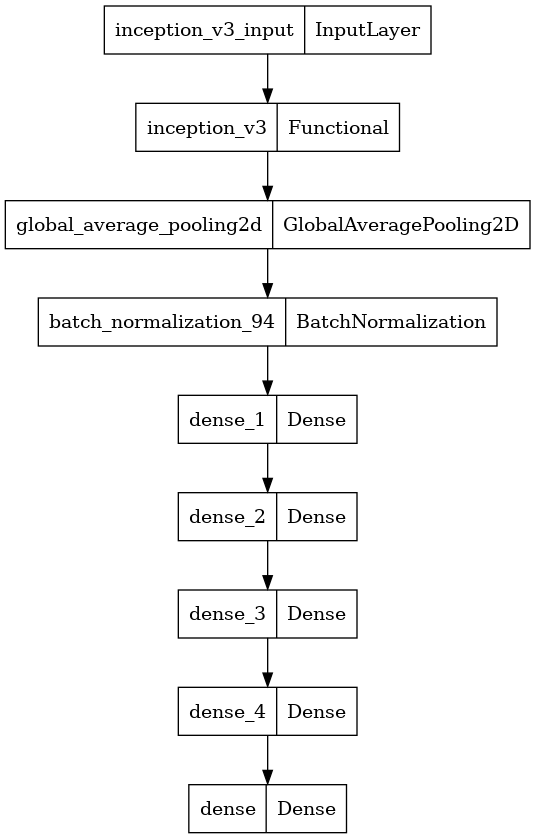

In [16]:
plot_model(model4)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 20.7 MB/s eta 0:00:0000:01


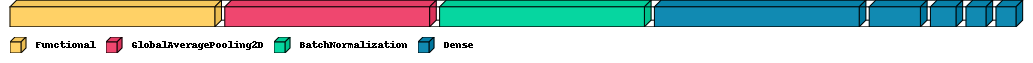

In [18]:
!pip install visualkeras
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model4, legend=True)

In [19]:
result = model4.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

80/80 [==============================] - 21s 261ms/step - loss: 0.1760 - accuracy: 0.9338 - auc: 0.9935 - precision: 0.9380 - recall: 0.9308
Train Loss = 0.17604346573352814
Train Accuracy = 0.9337761402130127
Train AUC = 0.9935114979743958
Train Precision = 0.9379921555519104
Train Recall = 0.9308458566665649


In [20]:
filepath = './InceptionV3_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'auto' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='auto', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [21]:
history3 = model4.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 50, callbacks = callback_list,
                        verbose = 1, batch_size=16)

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9531 - auc: 0.9981 - precision: 0.9528 - recall: 0.9453
Epoch 1: val_accuracy improved from -inf to 0.85759, saving model to ./InceptionV3_best_weights.hdf5
2/2 [==============================] - 2s 2s/step - loss: 0.1223 - accuracy: 0.9531 - auc: 0.9981 - precision: 0.9528 - recall: 0.9453 - val_loss: 0.3956 - val_accuracy: 0.8576 - val_auc: 0.9749 - val_precision: 0.8628 - val_recall: 0.8560
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.1446 - accuracy: 0.9609 - auc: 0.9961 - precision: 0.9609 - recall: 0.9609
Epoch 2: val_accuracy did not improve from 0.85759
2/2 [==============================] - 1s 895ms/step - loss: 0.1446 - accuracy: 0.9609 - auc: 0.9961 - precision: 0.9609 - recall: 0.9609 - val_loss: 0.4191 - val_accuracy: 0.8466 - val_auc: 0.9727 - val_precision: 0.8565 - val_recall: 0.8404
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.2244 - accu

In [22]:
model4.evaluate(test_generator)

11/11 [==============================] - 1s 100ms/step - loss: 0.4256 - accuracy: 0.8583 - auc: 0.9738 - precision: 0.8669 - recall: 0.8520


[0.42555370926856995,
 0.8582554459571838,
 0.9738049507141113,
 0.8668779730796814,
 0.8520249128341675]

In [24]:
result = model4.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]

print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')


11/11 [==============================] - 1s 51ms/step - loss: 0.4256 - accuracy: 0.8583 - auc: 0.9738 - precision: 0.8669 - recall: 0.8520
Test Loss = 0.42555341124534607
Test Accuracy = 0.8582554459571838
Test AUC = 0.9738049507141113
Test Precision = 0.8668779730796814
Test Recall = 0.8520249128341675


# **Plotting Results**

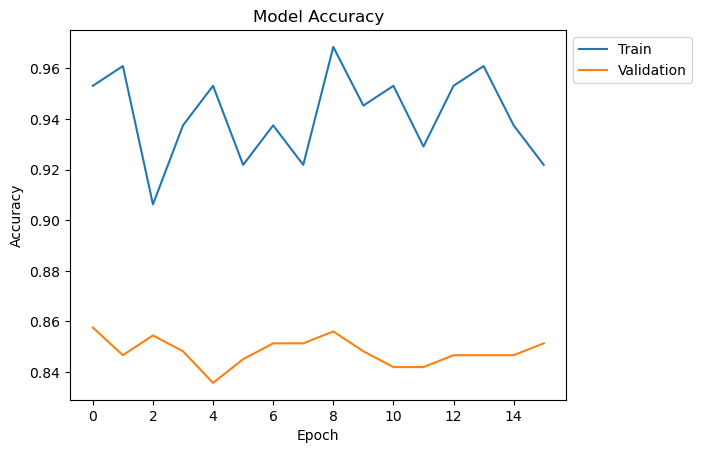

In [32]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

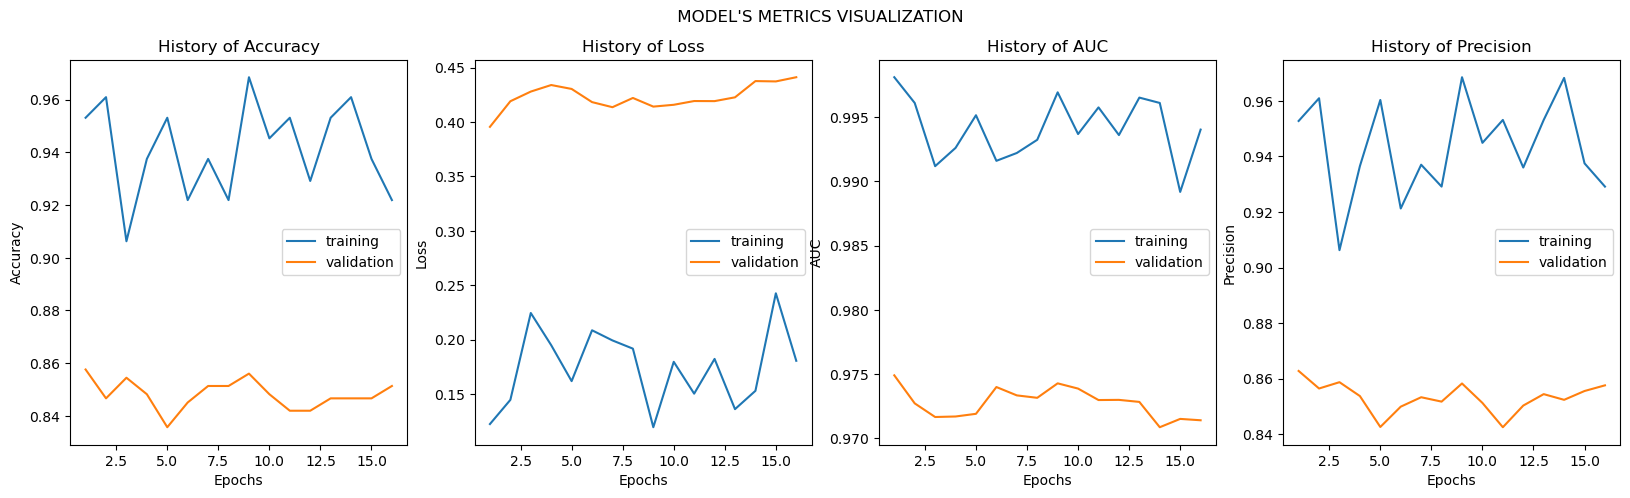

In [26]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
  


    plt.show()
    

Train_Val_Plot(history3.history['accuracy'],history3.history['val_accuracy'],
               history3.history['loss'],history3.history['val_loss'],
               history3.history['auc'],history3.history['val_auc'],
               history3.history['precision'],history3.history['val_precision']
              )

**From the graph we are able to visualize that the model is overfitting.**

In [27]:
# Generate predictions
train_predictions = model4.predict(train_generator)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

validation_predictions = model4.predict(validation_generator)
validation_predicted_labels = np.argmax(validation_predictions, axis=1)
validation_true_labels = validation_generator.classes

test_predictions = model4.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

# Calculate confusion matrices
train_cm = confusion_matrix(train_true_labels, train_predicted_labels)
validation_cm = confusion_matrix(validation_true_labels, validation_predicted_labels)
test_cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Define class labels (modify based on your specific problem)
class_labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

11/11 [==============================] - 1s 45ms/step


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# **Confusion Matrix**

Confusion matrix, without normalization


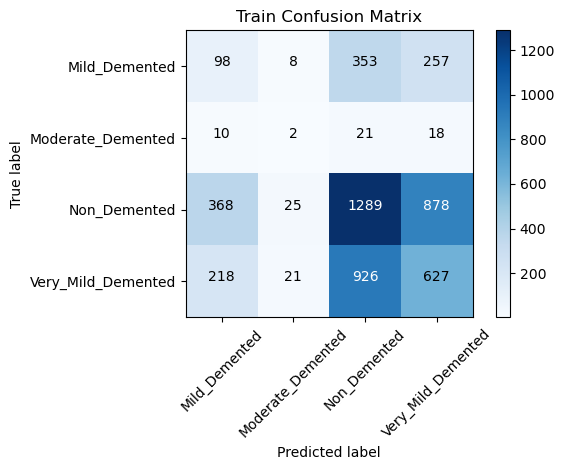

Confusion matrix, without normalization


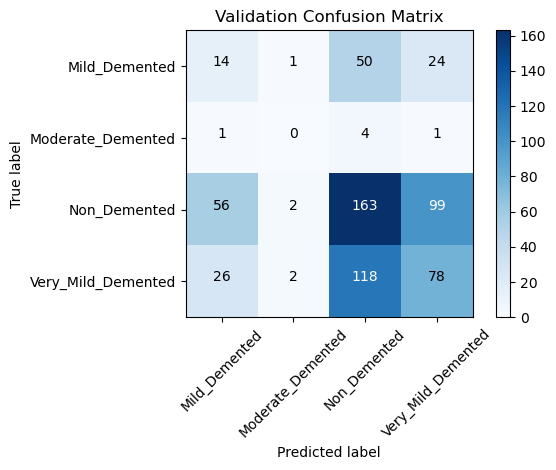

Confusion matrix, without normalization


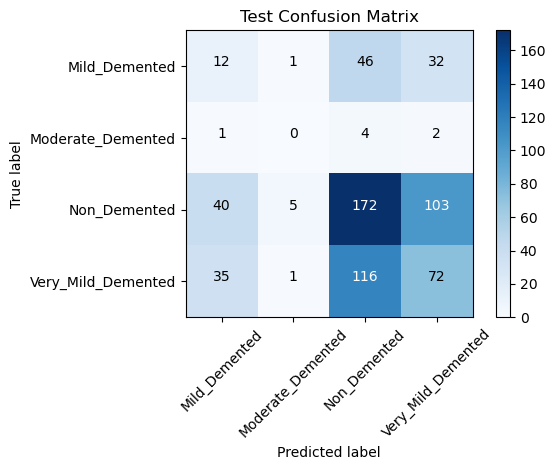

In [30]:
import itertools
# Calculate confusion matrices
train_cm = confusion_matrix(train_true_labels, train_predicted_labels)
validation_cm = confusion_matrix(validation_true_labels, validation_predicted_labels)
test_cm = confusion_matrix(test_true_labels, test_predicted_labels)

# Define class labels (modify based on your specific problem)
class_labels = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

# Plot confusion matrices
plot_confusion_matrix(train_cm, classes=class_labels, title='Train Confusion Matrix')
plt.show()

plot_confusion_matrix(validation_cm, classes=class_labels, title='Validation Confusion Matrix')
plt.show()

plot_confusion_matrix(test_cm, classes=class_labels, title='Test Confusion Matrix')
plt.show()